In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [6]:
# Load dataset (as_supervised=True returns (image, label) pairs)
(train_data, test_data), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

# Resize and normalize function
def format_example(image, label):
    image = tf.image.resize(image, (160, 160))
    image = image / 255.0  # Normalize
    return image, label

# Apply preprocessing and batching
train_data = train_data.map(format_example).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(format_example).batch(32).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.8Z6R76_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


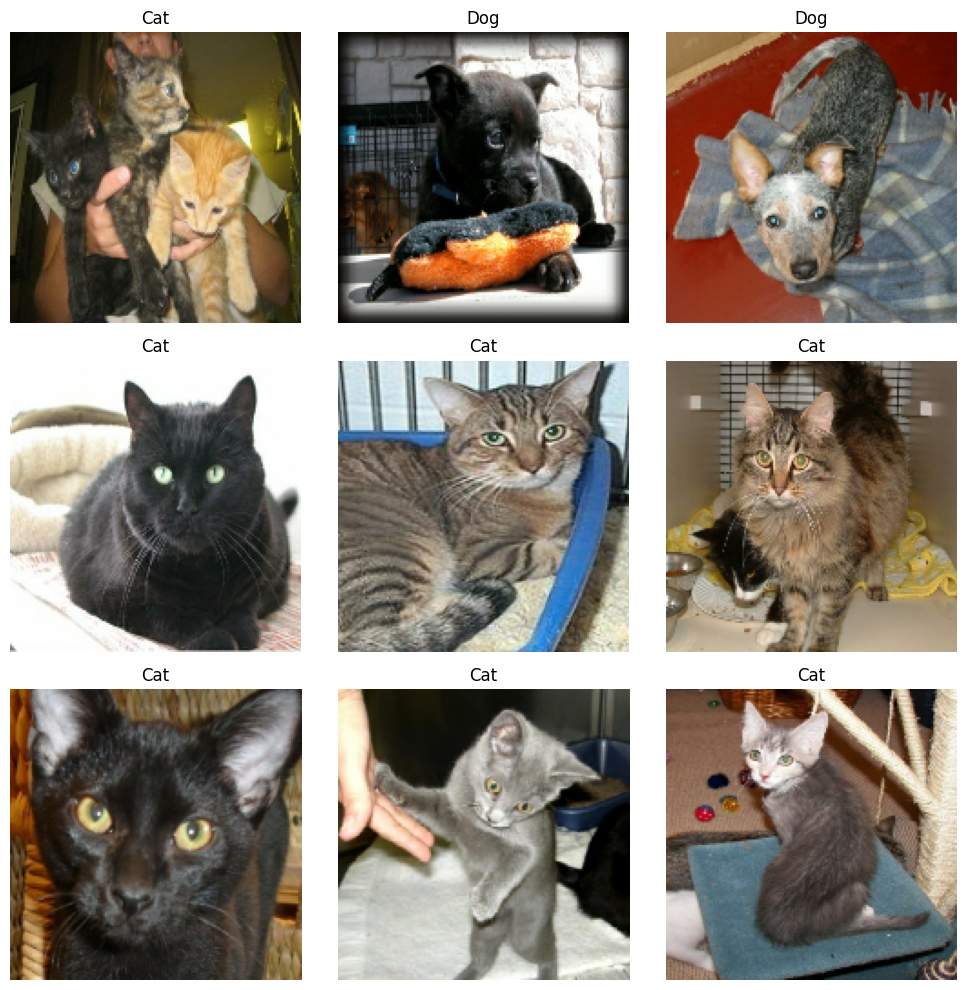

In [7]:
class_names = ['Cat', 'Dog']

for images, labels in train_data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [8]:
# Load MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze base

# Add classification head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
history = model.fit(train_data, epochs=3, validation_data=test_data)


Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 492s 830ms/step - accuracy: 0.9401 - loss: 0.1499 - val_accuracy: 0.9764 - val_loss: 0.0622
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 504s 835ms/step - accuracy: 0.9784 - loss: 0.0593 - val_accuracy: 0.9802 - val_loss: 0.0574
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 533s 914ms/step - accuracy: 0.9826 - loss: 0.0514 - val_accuracy: 0.9807 - val_loss: 0.0572


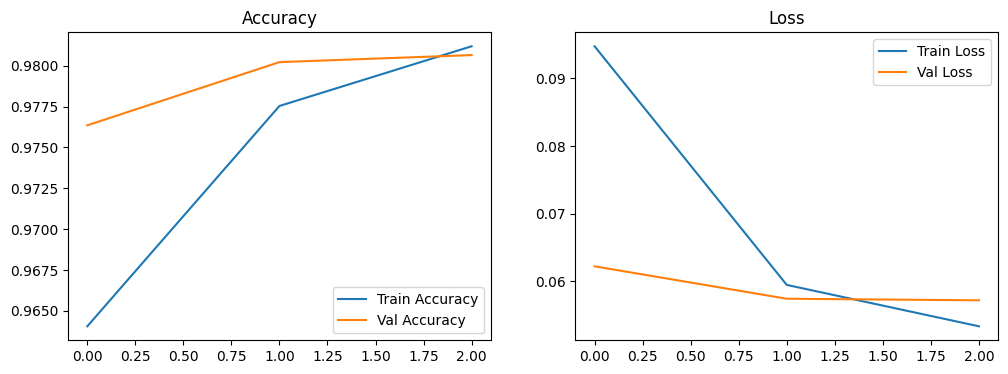

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(3)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-156692874.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_class = class_names[int(preds[i] > 0.5)]


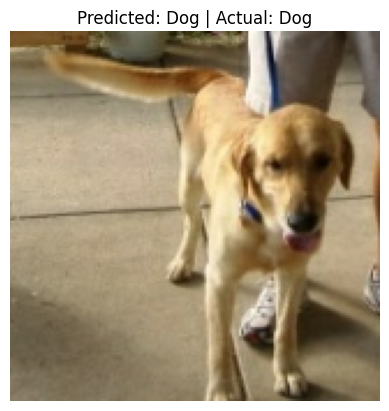

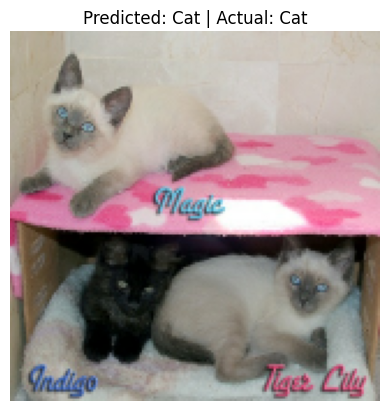

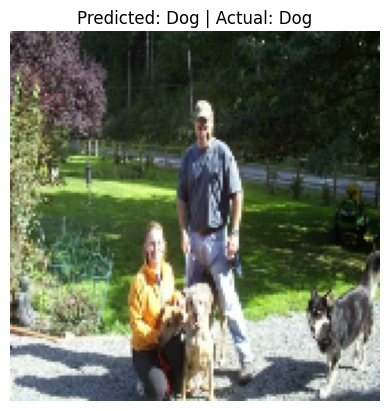

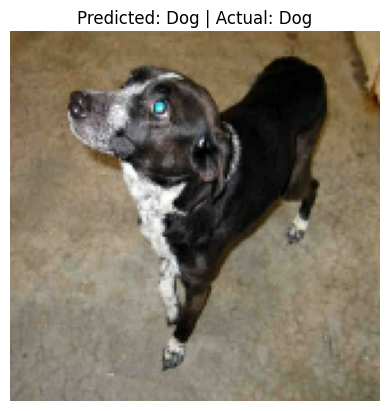

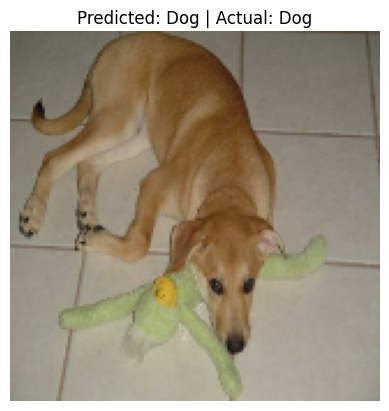

In [11]:
for images, labels in test_data.take(1):
    preds = model.predict(images)
    for i in range(5):
        plt.imshow(images[i].numpy())
        pred_class = class_names[int(preds[i] > 0.5)]
        true_class = class_names[labels[i]]
        plt.title(f"Predicted: {pred_class} | Actual: {true_class}")
        plt.axis("off")
        plt.show()


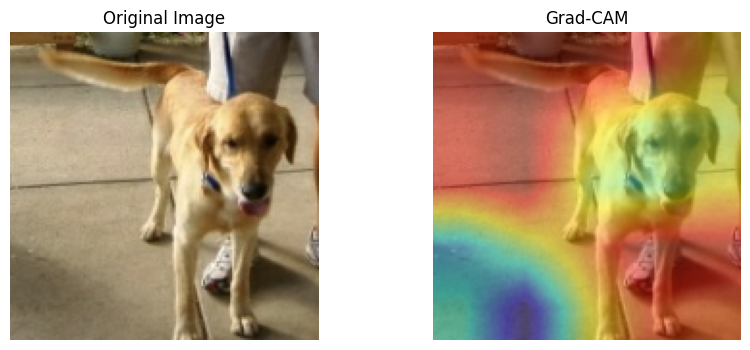

In [17]:
import cv2
import matplotlib.cm as cm

# Pick an image from test_data
for image_batch, label_batch in test_data.take(1):
    image = image_batch[0]  # (160,160,3)
    label = label_batch[0]
    break

img_array = tf.expand_dims(image, axis=0)

# Rebuild the feature extractor (MobileNetV2) part from your existing model
last_conv_layer_name = "Conv_1"  # Last conv layer in MobileNetV2

# Create a sub-model: input -> last conv layer -> output
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer(last_conv_layer_name).output
)

# Forward pass through the conv model and your classifier
with tf.GradientTape() as tape:
    conv_output = feature_extractor(img_array)
    tape.watch(conv_output)

    # Pass through remaining layers (GlobalPool + Dense)
    x = tf.keras.layers.GlobalAveragePooling2D()(conv_output)
    preds = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Gradient of class output wrt conv layer
    loss = preds[0]

grads = tape.gradient(loss, conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight the conv layer output
conv_output = conv_output[0]
heatmap = conv_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Normalize heatmap
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

# Resize and overlay
heatmap = cv2.resize(heatmap.numpy(), (160, 160))
heatmap = np.uint8(255 * heatmap)
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Prepare original image
original_image = np.uint8(image.numpy() * 255)

# Overlay heatmap on original image
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

# Display results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis("off")
plt.show()
